# 1. 자율주행 보조장치 (1) KITTI 데이터셋

이번 시간에 만들어 볼 자율주행 보조장치는 카메라에 사람이 탐지되었을 때, 그리고 차가 가까워져서 탐지된 크기가 일정 크기 이상일 때를 판단해야 합니다.

> 자율주행 보조장치 object detection 요구사항
> 
> * 사람이 카메라에 감지되면 정지
> * 차량이 일정 크기 이상으로 감지되면 정지

이번 시간에는 tensorflow_datasets에서 제공하는 KITTI 데이터셋을 사용해보겠습니다. KITTI 데이터셋은 자율주행을 위한 데이터셋으로 2D object detection 뿐만 아니라 깊이까지 포함한 3D object detection 라벨 등을 제공하고 있습니다.

먼저 필요한 라이브러리를 불러 오겠습니다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = '/content/drive/MyDrive/AIFFEL/DATASET/GoingDeeper/06'

아래 코드를 통해서 KITTI 데이터셋을 다운로드해 주세요. 30-40분 정도 걸립니다.

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

다운로드한 KITTI 데이터셋을 tfds.show_examples를 통해 보도록 합시다. 우리가 일반적으로 보는 사진보다 광각으로 촬영되어 다양한 각도에서의 물체를 확인할 수 있습니다.

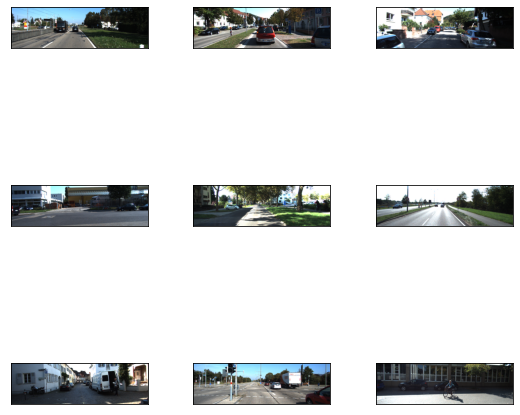

In [4]:
_ = tfds.show_examples(ds_train, ds_info)

데이터 다운로드 시 담아둔 `ds_info`에서는 불러온 데이터셋의 정보를 확인할 수 있습니다. 오늘 사용할 데이터셋은 6,347개의 학습 데이터(training data), 711개의 평가용 데이터(test data), 423개의 검증용 데이터(validation data)로 구성되어 있습니다. 라벨에는 `alpha`, `bbox`, `dimensions`, `location`, `occluded`, `rotation_y`, `truncated` 등의 정보가 있습니다.



In [5]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/content/drive/MyDrive/AIFFEL/DATASET/GoingDeeper/06/kitti/3.2.0',
    file_format=tfrecord,
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequenc

# 2. 자율주행 보조장치 (2) 데이터 직접 확인하기

이번에는 데이터셋을 직접 확인하는 시간을 갖도록 하겠습니다. `ds_train.take(1)`을 통해서 데이터셋을 하나씩 뽑아볼 수 있는 sample을 얻을 수 있습니다. 이렇게 뽑은 데이터에는 image 등의 정보가 포함되어 있습니다.

눈으로 확인해서 학습에 사용할 데이터를 직접 이해해 봅시다.

------Example------
['image', 'image/file_name', 'objects']
------Objects------
{'alpha': <tf.Tensor: shape=(6,), dtype=float32, numpy=array([ 1.36,  2.74,  1.32, -1.63,  1.88,  1.72], dtype=float32)>, 'bbox': <tf.Tensor: shape=(6, 4), dtype=float32, numpy=
array([[0.0027027 , 0.9021732 , 0.6766216 , 0.9972141 ],
       [0.00891892, 0.8786765 , 0.63248646, 0.9481209 ],
       [0.0027027 , 0.82270426, 0.66564864, 0.8924183 ],
       [0.47494593, 0.59741014, 0.56494594, 0.62414217],
       [0.44005406, 0.5826879 , 0.5574595 , 0.5943954 ],
       [0.43627027, 0.56715685, 0.5519459 , 0.579951  ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[1.93, 0.71, 0.46],
       [1.8 , 0.8 , 0.5 ],
       [1.92, 0.61, 0.5 ],
       [1.91, 1.65, 4.4 ],
       [1.81, 0.58, 0.84],
       [1.77, 0.64, 0.88]], dtype=float32)>, 'location': <tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[ 4.  ,  1.52,  5.08],
       [ 4.17,  1.45,  5.95],
       [ 3.29,  1.53

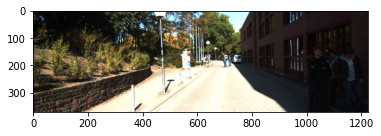

In [6]:
sample = ds_train.take(1)

for example in sample:
  print('------Example------')
  print(list(example.keys()))
  image = example["image"]
  filename = example["image/file_name"].numpy().decode('utf-8')
  objects = example["objects"]

print('------Objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

이미지와 라벨을 얻는 방법을 알게 되었습니다. 그렇다면 이렇게 얻은 이미지의 바운딩 박스(bounding box, `bbox`)를 확인하기 위해서는 어떻게 해야 할까요?

아래는 KITTI에서 제공하는 데이터셋에 대한 설명입니다.


```
데이터셋 이해를 위한 예시
Values    Name      Description
----------------------------------------------------------------------------
   1    type         Describes the type of object: 'Car', 'Van', 'Truck',
                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                     'Misc' or 'DontCare'
   1    truncated    Float from 0 (non-truncated) to 1 (truncated), where
                     truncated refers to the object leaving image boundaries
   1    occluded     Integer (0,1,2,3) indicating occlusion state:
                     0 = fully visible, 1 = partly occluded
                     2 = largely occluded, 3 = unknown
   1    alpha        Observation angle of object, ranging [-pi..pi]
   4    bbox         2D bounding box of object in the image (0-based index):
                     contains left, top, right, bottom pixel coordinates
   3    dimensions   3D object dimensions: height, width, length (in meters)
   3    location     3D object location x,y,z in camera coordinates (in meters)
   1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]
   1    score        Only for results: Float, indicating confidence in
                     detection, needed for p/r curves, higher is better.

```



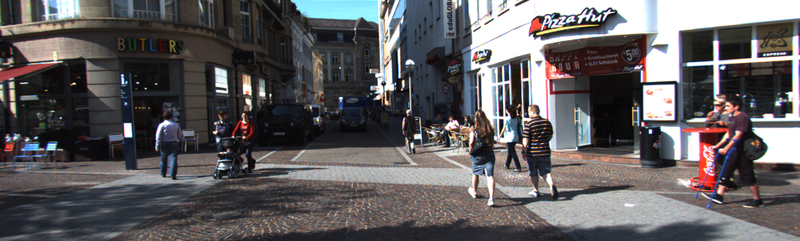

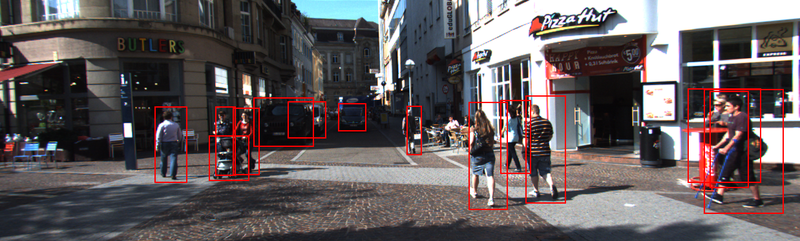

위 설명과 예시 이미지를 참고하셔서 이미지 위에 바운딩 박스를 그려서 시각화해 보세요!

[Pillow 라이브러리의 ImageDraw 모듈](https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html)을 참고하세요.

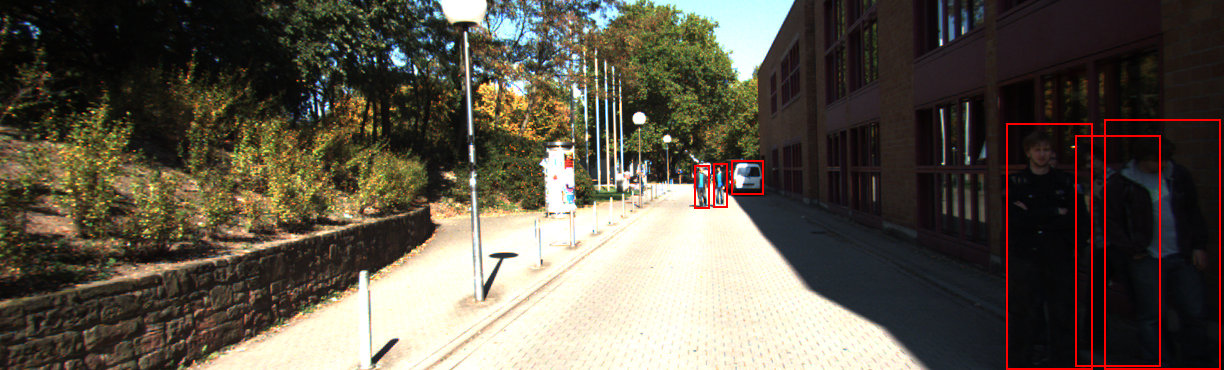

In [7]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
      draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

# 3. 데이터 준비

## 데이터 파이프 라인

먼저 주어진 KITTI 데이터를 학습에 맞는 형태로 바꿉니다. 이 때 사용할 데이터 파이프라인을 구축합니다.

총 4단계로 이루어져 있습니다.

1. x와 y 좌표의 위치 교체  
2. 무작위로 수평 뒤집기(flip)
3. 이미지 크기 조정 및 패딩 추가
4. 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]로 수정

독립적인 함수를 각각 작성합니다.

In [8]:
def swap_xy(boxes):
  return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

In [9]:
def random_flip_horizontal(image, boxes):
  if tf.random.uniform(()) > 0.5:
    image = tf.image.flip_left_right(image)
    boxes = tf.stack(
        [1 - boxes[:, 2], boxes[:, 1], 1- boxes[:, 0], boxes[:, 3]], axis=-1
    )
  return image, boxes

이미지의 크기를 바꿀 때 주의사항이 있습니다. 이미지의 비율은 그대로 유지되어야 하고, 이미지의 최대/최소 크기도 제한해야 합니다. 또 이미지의 크기를 바꾼 후에도 최종적으로 모델에 입력되는 이미지의 크기는 stride의 배수가 되도록 만들어야 합니다.

실제로 입력할 이미지를 어떻게 바꿀지는 `min_side`, `max_side`, `min_side_range`, `stride` 등에 의해 결정됩니다. 그리고 학습이 완료된 모델을 사용할 때는 입력할 이미지를 다양한 크기로 바꿀 필요는 없으니 분기처리를 해줍니다.

In [10]:
def resize_and_pad_image(image, training=True):

  min_side = 800.0
  max_side = 1333.0
  min_side_range = [640, 1024]
  stride = 128.0

  image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
  if training:
    min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
  ratio = min_side / tf.reduce_min(image_shape)

  if ratio * tf.reduce_max(image_shape) > max_side:
    ratio = max_side / tf.reduce_max(image_shape)
  image_shape = ratio * image_shape
  image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
  padded_image_shape = tf.cast(
      tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
  )
  image = tf.image.pad_to_bounding_box(
      image, 0, 0, padded_image_shape[0], padded_image_shape[1]
  )
  return image, image_shape, ratio

In [11]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

이제 준비된 함수들을 연결해 줍니다.

In [12]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

## 인코딩

One stage detector에서는 Anchor Box라는 정해져 있는 위치, 크기, 비율 중에 하나로 물체의 위치가 결정됩니다. 그래서 기본적으로 Anchor Box를 생성해줘야 합니다. Anchor Box로 생성되는 것은 물체 위치 후보라고 생각하면 됩니다. 물체 위치를 주관식이 아닌 객관식으로 풀게 하는 겁니다.

여기서는 논문과 같은 형태로 Anchor Box를 생성합니다.

In [13]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

이제 Anchor Box를 생성했으니 입력할 데이터를 Anchor Box에 맞게 변형해줘야 합니다.

데이터 원본의 bbox는 주관식 정답이라고 생각하면 됩니다. 하지만 모델은 객관식으로 문제를 풀어야 하기 때문에 주관식 정답을 가장 가까운 객관식 정답으로 바꿔줘야 모델을 학습시킬 수 있습니다.

그럼 어떻게 주관식 정답을 객관식 정답으로 바꿀 수 있을까요? 여기에서 IoU를 사용합니다.

IoU가 높은지 낮은지에 따라 Anchor Box가 정답인지 오답인지 체크해 두는 것이죠. 그러니 IoU를 계산할 수 있는 함수를 만듭니다.

In [14]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

이제 실제 라벨을 Anchor Box에 맞춰주는 클래스를 만들 차례입니다. 위에서 작성한 `compute_iou`를 이용해서 IoU를 구하고 그 IoU를 기준으로 물체에 해당하는 Anchor Box와 배경이 되는 Anchor Box를 지정해 줍니다. 그리고 그 Anchor Box와 실제 Bounding Box의 미세한 차이를 계산합니다. 상하좌우의 차이, 가로세로 크기의 차이를 기록해 두는데 가로세로 크기는 로그를 사용해서 기록해 둡니다.

In [15]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

# 4. 모델 작성

## Feature Pyramid

앞서 설명했듯이 RetinaNet에서는 FPN(Feature Pyramid Network)를 사용합니다. 


In [16]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

Object Detection의 라벨은 class와 box로 이루어지므로 각각을 추론하는 부분이 필요합니다. 그것을 head라고 부르기도 합니다. head부분은 유사한 형태로 만들 수 있으니 `build_head`라는 함수를 하나만 만들고 두 번 호출하면 될 것 같네요.

In [17]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

우리가 만들 RetinaNet의 backbone은 ResNet50입니다. FPN에 이용할 수 있도록 중간 레이어도 output으로 연결해 줍니다.

In [18]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )


이제 RetinaNet을 완성해 봅시다. Backbone + FPN + classification용 head + box용 head 입니다.

In [19]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

이제 모델은 준비 완료했으니, Loss에 대한 준비도 해봅시다.

RetinaNet에서는 Focal Loss를 사용하는데요. Box Regression에는 사용하지 않고 Classification Loss를 계산하는데만 사용됩니다. Box Regression에는 Smooth L1 Loss를 사용했네요.

Smooth L1 Loss을 사용하는 Box Regression에는 delta를 기준으로 계산이 달라지고, Focal Loss를 사용하는 Classification에서는 alpha와 gamma를 사용해서 물체일 때와 배경일 때의 식이 달라지는 점에 주의하세요!

In [20]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

# 5. 모델 학습

앞에서 만들어 놓은 클래스와 함수를 이용해서 모델을 조립하고 학습!!

In [21]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

94781440/94765736 [==============================] - 1s 0us/step


다음으로 Learning Rate입니다. 논문에서는 8개의 GPU를 사용했기 때문에 지금은 환경이 다소 안 맞습니다. 때문에 적절히 바꿔줘야 합니다.

Optimizer는 동일하게 SGD를 사용합니다.

In [22]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

이제 데이터 전처리를 위한 파이프라인도 만들어 줍니다.

In [23]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

이제 학습을 시켜봅니다.

1 epoch 당 학습 시간이 상당히 오래 걸립니다!! 아래처럼 코드를 돌리고 잠시 산책을 다녀오거나 스트레칭으로 굳은 몸 풀어줘도 되구요~~

In [25]:
model_dir = '/content/drive/MyDrive/AIFFEL/DATASET/GoingDeeper/06/checkpoint'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

epochs = 1

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)

3173/3173 [==============================] - ETA: 0s - loss: 1.1851
Epoch 1: saving model to /content/drive/MyDrive/AIFFEL/DATASET/GoingDeeper/06/checkpoint/weights_epoch_1
3173/3173 [==============================] - 1674s 526ms/step - loss: 1.1851 - val_loss: 1.3400


# 6. 결과 확인하기

학습된 모델을 불러옵시다.

In [26]:
model_dir = '/content/drive/MyDrive/AIFFEL/DATASET/GoingDeeper/06/checkpoint'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

모델의 추론 결과를 처리할 함수를 레이어 형식으로 만들어 줍니다. 논문에서는 1000개의 후보를 골라 처리했지만 우리는 100개의 후보만 골라 처리하도록 합시다. 나머지 설정은 논문과 동일하게 해볼게요.

NMS(Non-Max Suppression)은 직접 구현하지 않고 주어진 tf.image.combined_non_max_suppression를 사용했습니다.

[tf.image.combined_non_max_suppression](https://www.tensorflow.org/api_docs/python/tf/image/combined_non_max_suppression)

위 참고자료를 꼭 읽어보세요. 입출력되는 값이 어떤지 알아야 코드가 이해가 됩니다. 특히 출력에 nmsed_boxes, nmsed_scores, nmsed_classes, valid_detections이 각각 무엇인지 알아야 활용할 수 있습니다.

In [28]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

이제 추론이 가능한 모델을 조립합니다.

In [29]:
image = tf.keras.Input(shape=[None, None, 3], name='image')
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [30]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

이제 추론시에 입력 데이터를 전처리하기 위한 함수를 만들어야 합니다.

학습을 위한 전처리와 추론을 위한 전처리가 다르기 때문에 따로 작성됩니다. 추론을 위한 전처리가 훨씬 간단합니다.

In [31]:
def prepare_image(image):
  image, _, ratio = resize_and_pad_image(image, training=False)
  image = tf.keras.applications.resnet.preprocess_input(image)
  return tf.expand_dims(image, axis=0), ratio

이제 모든 것이 준비 되었으니 학습된 결과를 확인합시다!!

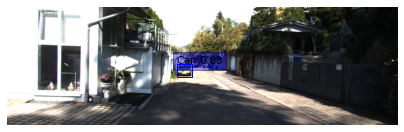

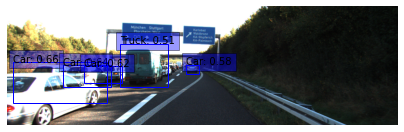

In [32]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )